In [3]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score

# catboost
from catboost import CatBoostClassifier, Pool, cv

In [4]:
train, test, leaderboard,holdout = load_files(nanvalues='remove')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1438) (294, 1438) (530, 1438) (803, 1438)


In [5]:
meta.head(5)

,varlab,type,one_topic,dtype
new_name,,,,
f1a2,Were you present at the birth?,Binary,parenting,float64
f1a3,Have you held baby(ies)?,Binary,parenting,float64
f1a4,Will the baby(ies) have your last name?,Binary,parenting,float64
f1a5,Will your name be on the birth certificate?,Binary,parenting,float64
f1a6,Do you have other biological children?,Binary,health_and_health_behavior,float64


# Model

In [ ]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    print(X_train.shape, y_train.shape)
    # get only predictors
    X_train = X_train[predictors[target]]
    print(X_train.shape, y_train.shape)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # ordered_transformer = Pipeline(steps=[
    #     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    #     ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ])

    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(600, 1500),
            'regressor__learning_rate': space.Real(0.01, 0.06),
            'regressor__max_depth': space.Integer(5, 10),
            'regressor__min_child_weight': space.Integer(3, 5),
            'regressor__gamma': space.Real(0.1, 0.25),
            'regressor__subsample': space.Real(0.5, 0.8),
            'regressor__colsample_bytree': space.Real(0.5, 0.8),
            'regressor__colsample_bylevel': space.Real(0.5, 0.8),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=32
    )
    
    # ytrain shape
    print(y_train.shape)
    model.fit(X_train, y_train)
    
    return model


# GPA

In [ ]:
gpa_model = run_model(alldata,target='gpa', classifier=False)

(1165,)


In [ ]:
gpa_model.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.6930185742702273),
             ('regressor__colsample_bytree', 0.7129848097433594),
             ('regressor__gamma', 0.23761168441239147),
             ('regressor__learning_rate', 0.03206794006125935),
             ('regressor__max_depth', 7),
             ('regressor__min_child_weight', 3),
             ('regressor__n_estimators', 1164),
             ('regressor__subsample', 0.6832829310430983)])

In [ ]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Metric: mean_squared_error
Best CV score: 0.4151
Standard deviation of CV scores: 0.0222
Mean CV score: 0.4202
Test MSE: 0.0149
Test R2: 0.9673
Leaderboard MSE: 0.5664
Leaderboard R2: -0.4500
Holdout MSE: 0.6005
Holdout R2: -0.4224


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


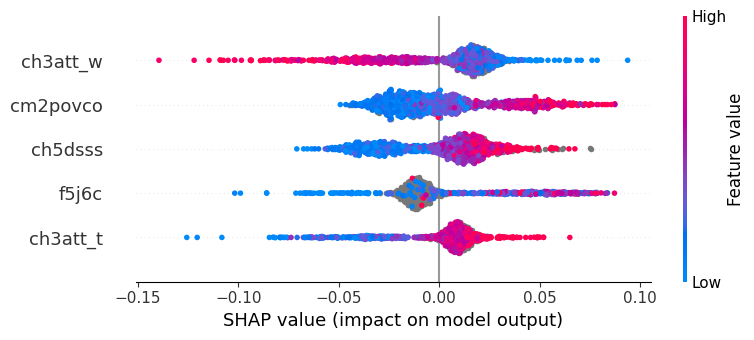

{('attention-seeking',): 'ch3att_t',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'f5j6c',
 ('Digit Span scaled score',): 'ch5dsss',
 ('J6C. Value of vehicle if sold',): 'cm2povco',
 ('cooperative',): 'ch3att_w'}

In [ ]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [ ]:
model_materialHardship = run_model(alldata,target='materialHardship', classifier=False)

(1459,)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


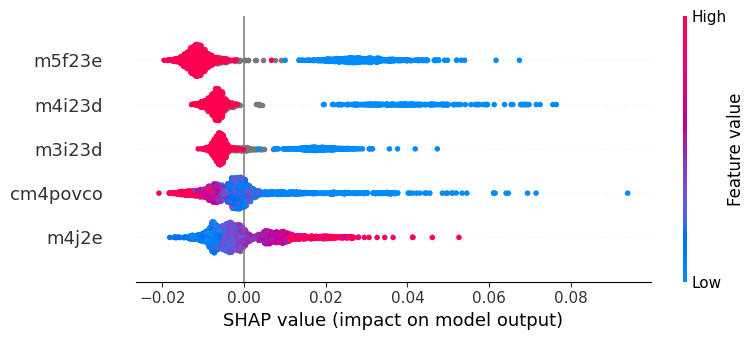

{('F23E. Did not pay full amount of gas/oil/electricity bill in past 12 months',): 'm4j2e',
 ("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'cm4povco',
 ('In past year, did you not pay full gas/oil/electricity bill?',): 'm3i23d',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'm4i23d',
 ('How much do you weigh?',): 'm5f23e'}

In [ ]:
shap_show(model_materialHardship, alldata, target='materialHardship')

In [ ]:
meta[meta.index == 'm4j2e']

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
m4j2e,How much do you weigh?,Continuous,health_and_health_behavior,float64,0.034165,0.041862,0.023383,0.005323,0.03128,0.022461


# Grit


In [ ]:
model_grit = run_model(alldata,target='grit', classifier=False)

(1948,)


KeyboardInterrupt: 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


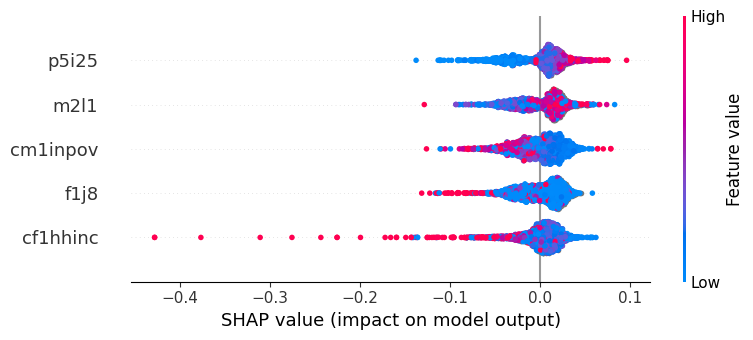

{("I25. Number of child's close friends you saw last week",): 'cf1hhinc',
 ('What was your total household income before taxes last year, all sources?',): 'f1j8',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm1inpov',
 ('About how much did you earn?',): 'm2l1',
 ('Constructed - Household income (with imputed values)',): 'p5i25'}

In [ ]:
shap_show(model_grit, alldata, target='grit')

# Eviction

In [ ]:
alldata

,cf1lenmin,cf1fint,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a5,f1a6,f1a7,...,cm5hhinc,cm5hhimp,cm5povco,cm5povca,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,,,,,,,,,,,,,,,,
3534,35.0,1,1,13.621670,1,1,1,1,2,101,...,72054.599733,4,3.788349,5,3.50,3.75,0.090909,0.0,1.0,0.0
2273,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22560.103689,4,1.062619,3,3.00,3.50,0.000000,0.0,0.0,1.0
69,0.0,1,1,161.652405,1,1,1,1,2,101,...,25391.686674,1,1.597379,3,3.00,2.75,0.181818,0.0,0.0,1.0
1593,45.0,1,1,79.580742,1,1,1,1,2,101,...,99324.346279,1,4.566672,5,3.00,3.75,0.000000,0.0,0.0,0.0
137,40.0,1,1,5.386045,1,1,1,1,2,1,...,33595.935895,4,0.808273,2,2.25,3.25,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4223,35.0,1,1,88.229759,1,1,1,1,2,1,...,75879.843756,4,2.746758,4,3.25,3.75,0.000000,False,False,False
4226,39.0,1,1,36.459396,1,1,1,1,1,4,...,88150.383120,2,3.326897,5,2.25,4.00,0.000000,False,False,True
4228,35.0,1,1,154.824493,1,1,1,1,1,1,...,101313.528095,1,5.385343,5,3.25,3.25,0.000000,False,False,False


In [ ]:
model_eviction = run_model(alldata,target='eviction', classifier=True)

(2792,)


ValueError: y should be a 1d array, got an array of shape (559, 2) instead.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


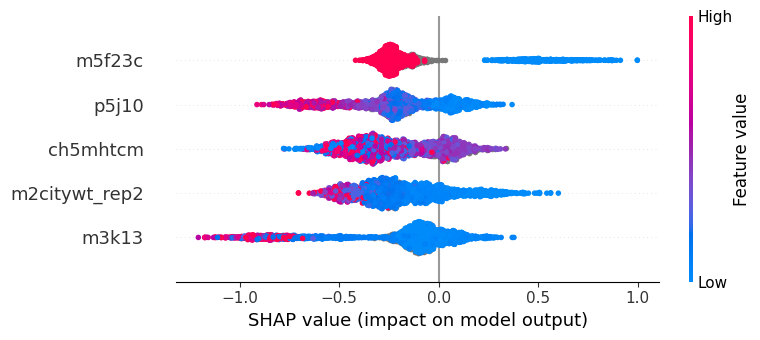

{('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'm3k13',
 ('J10. Amount of money spent eating out in last month',): 'm2citywt_rep2',
 ("BioMom's height in cm",): 'ch5mhtcm',
 ('Mother one-year city replicate weight no. 2',): 'p5j10',
 ('About how much do/did you earn in this/that job before taxes? ($)',): 'm5f23c'}

In [ ]:
shap_show(model_eviction, alldata, target='eviction')

In [ ]:
meta[meta.index == 'p5j10']

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
p5j10,J10. Amount of money spent eating out in last ...,Continuous,finances,float64,0.0,0.012956,0.0,0.022455,0.0,0.0


# jobTraining

In [ ]:
model_job = run_model(alldata,target='jobTraining', classifier=True)

(2264,)


ValueError: y should be a 1d array, got an array of shape (453, 2) instead.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


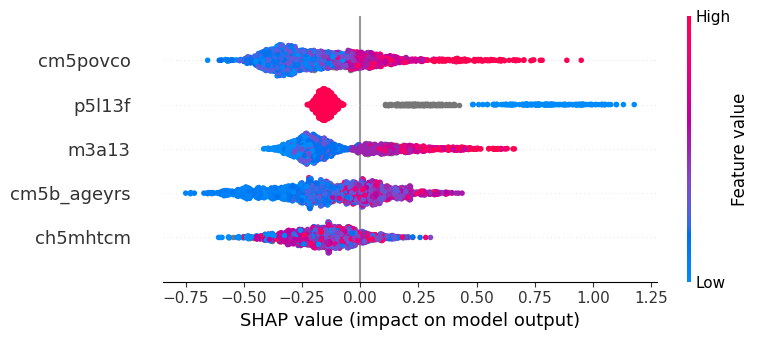

{("Constructed - Mother's household income/poverty threshold at 9-year",): 'ch5mhtcm',
 ('L13F. Gifted and talented program',): 'cm5b_ageyrs',
 ('Before father, how many romantic relationships lasted at least one month?',): 'm3a13',
 ('Constructed - Child age at time of mother interview (years)',): 'p5l13f',
 ("BioMom's height in cm",): 'cm5povco'}

In [ ]:
shap_show(model_job, alldata, target='jobTraining')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


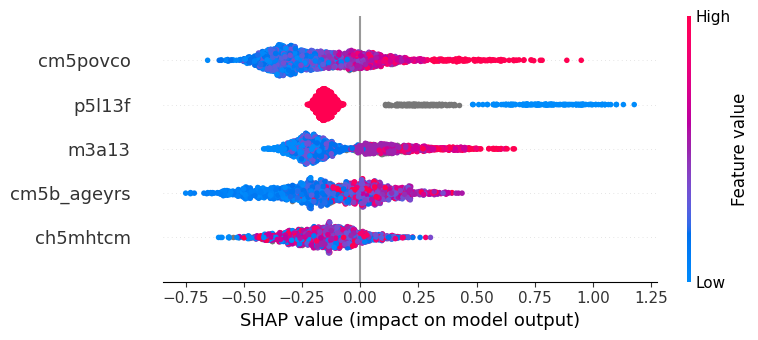

{("Constructed - Mother's household income/poverty threshold at 9-year",): 'ch5mhtcm',
 ('L13F. Gifted and talented program',): 'cm5b_ageyrs',
 ('Before father, how many romantic relationships lasted at least one month?',): 'm3a13',
 ('Constructed - Child age at time of mother interview (years)',): 'p5l13f',
 ("BioMom's height in cm",): 'cm5povco'}

In [ ]:
shap_show(model_job, alldata, target='jobTraining')

In [ ]:
top5 = ['m5i2_1','p5l13f','cm5hhinc']

meta[meta.index.isin(top5)].varlab.values

array(['L13F. Gifted and talented program',
       "Constructed - Mother's Household income (with imputed values)"],
      dtype=object)

# Layoff

In [ ]:
model_layoff = run_model(alldata, target='layoff', classifier=True)

(2610,)


ValueError: y should be a 1d array, got an array of shape (522, 2) instead.

In [ ]:
model_layoff.best_params_

OrderedDict([('regressor__colsample_bylevel', 0.5676045212957774),
             ('regressor__colsample_bytree', 0.7481910537426258),
             ('regressor__gamma', 0.13878315656639287),
             ('regressor__learning_rate', 0.030320321868167514),
             ('regressor__max_depth', 10),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 1001),
             ('regressor__scale_pos_weight', 4),
             ('regressor__subsample', 0.554328658963856)])

In [ ]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Test Brier: 0.2558
Test F1: 0.0571
Leaderboard Brier: 0.2679
Leaderboard F1: 0.1446
Holdout Brier: 0.2416


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


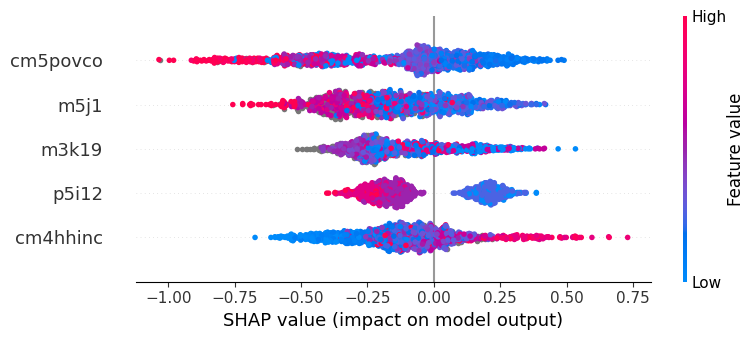

{("Constructed - Mother's household income/poverty threshold at 9-year",): 'cm4hhinc',
 ('J1. Total household income before taxes/deductions in past 12 months',): 'p5i12',
 ('How much did you earn from all regular jobs in past year? ($)',): 'm3k19',
 ('I12. Number of hours child sleeps on weeknights',): 'm5j1',
 ('Constructed - Household income (with imputed values)',): 'cm5povco'}

In [ ]:
shap_show(model_layoff, alldata, target='layoff')